# SVM Experimentation Notebook (Pre-Final Training)

This notebook demonstrates **extensive experimentation of SVM classifiers** on CNN-extracted feature vectors before finalizing the training pipeline.

**Objectives:**
- Analyze feature separability
- Compare Linear vs RBF SVM
- Study effect of hyperparameters (C, gamma)
- Justify final SVM choice

In [1]:
import os, sys, cv2
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

sys.path.append(os.path.abspath('..'))
from src.feature_extractor import extract_features

## Load Dataset and Extract CNN Features

In [2]:
DATASET_DIR = '../dataset'
CATEGORIES = {'with_mask': 1, 'without_mask': 0}

X, y = [], []
for category, label in CATEGORIES.items():
    folder = os.path.join(DATASET_DIR, category)
    for fname in os.listdir(folder):
        img = cv2.imread(os.path.join(folder, fname))
        if img is None: continue
        X.append(extract_features(img))
        y.append(label)

X = np.array(X)
y = np.array(y)
print('Samples:', X.shape[0])
print('Feature dimension:', X.shape[1])

Samples: 500
Feature dimension: 1922


## Train-Test Split

In [3]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

## PCA Visualization of Feature Space

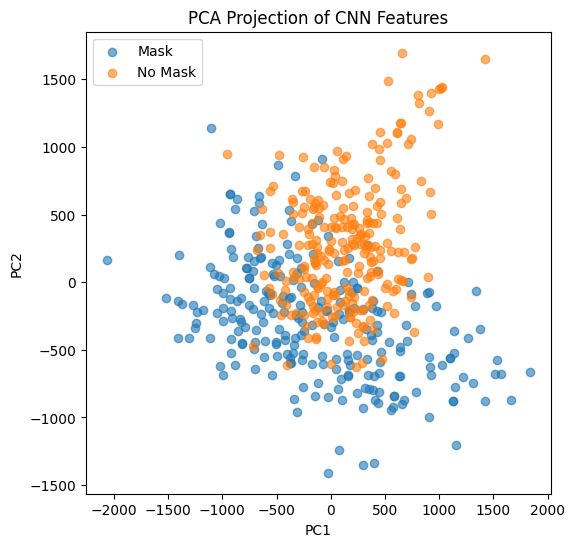

In [4]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

plt.figure(figsize=(6,6))
plt.scatter(X_pca[y==1,0], X_pca[y==1,1], alpha=0.6, label='Mask')
plt.scatter(X_pca[y==0,0], X_pca[y==0,1], alpha=0.6, label='No Mask')
plt.legend(); plt.xlabel('PC1'); plt.ylabel('PC2')
plt.title('PCA Projection of CNN Features')
plt.show()

## Linear SVM Experimentation

In [5]:
C_values = [0.01, 0.1, 1, 10]
linear_acc = []

for C in C_values:
    model = Pipeline([
        ('scaler', StandardScaler()),
        ('svm', SVC(kernel='linear', C=C))
    ])
    model.fit(X_train, y_train)
    acc = accuracy_score(y_test, model.predict(X_test))
    linear_acc.append(acc)
    print(f'Linear SVM | C={C} | Accuracy={acc:.3f}')

Linear SVM | C=0.01 | Accuracy=0.920
Linear SVM | C=0.1 | Accuracy=0.920
Linear SVM | C=1 | Accuracy=0.920
Linear SVM | C=10 | Accuracy=0.920


## RBF SVM Experimentation

In [6]:
gamma_values = [0.001, 0.01, 0.1, 'scale']
rbf_acc = []

for gamma in gamma_values:
    model = Pipeline([
        ('scaler', StandardScaler()),
        ('svm', SVC(kernel='rbf', C=1.0, gamma=gamma))
    ])
    model.fit(X_train, y_train)
    acc = accuracy_score(y_test, model.predict(X_test))
    rbf_acc.append(acc)
    print(f'RBF SVM | gamma={gamma} | Accuracy={acc:.3f}')

RBF SVM | gamma=0.001 | Accuracy=0.880
RBF SVM | gamma=0.01 | Accuracy=0.500
RBF SVM | gamma=0.1 | Accuracy=0.500
RBF SVM | gamma=scale | Accuracy=0.920


## Accuracy Comparison Plot

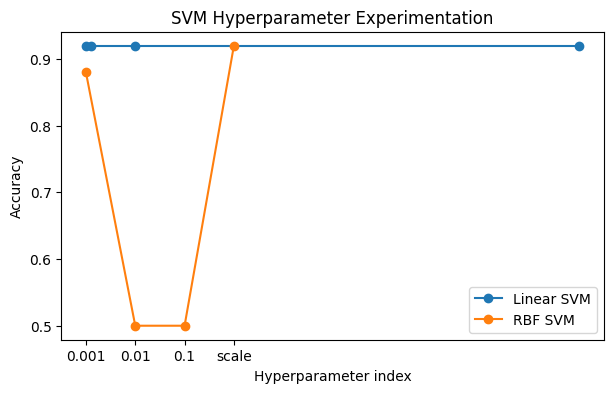

In [7]:
plt.figure(figsize=(7,4))
plt.plot(C_values, linear_acc, marker='o', label='Linear SVM')
plt.plot(range(len(gamma_values)), rbf_acc, marker='o', label='RBF SVM')
plt.xticks(range(len(gamma_values)), gamma_values)
plt.xlabel('Hyperparameter index')
plt.ylabel('Accuracy')
plt.title('SVM Hyperparameter Experimentation')
plt.legend()
plt.show()

## Conclusion

- Linear SVM works when CNN features are near-linearly separable.
- RBF SVM offers better robustness to feature overlap.
- Feature scaling is essential.

**Final decision:** RBF SVM + StandardScaler.